In [1]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, confusion_matrix, classification_report, precision_recall_curve, recall_score)
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import shap

C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv('Breast_cancer_data.csv')
feature_names = data.columns.drop('diagnosis').tolist()
X = data.drop('diagnosis', axis=1).values
y = data['diagnosis'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.25, random_state=42
)

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [5]:
# Combine for resampling
df = pd.DataFrame(X_train)
df['label'] = y_train
df_majority = df[df.label == 0]
df_minority = df[df.label == 1]
# Upsample malignant to 3x majority
df_min_up = resample(df_minority, replace=True, n_samples=len(df_majority)*3, random_state=42)
df_resampled = pd.concat([df_majority, df_min_up])
X_train_up = df_resampled.drop('label', axis=1).values
y_train_up = df_resampled['label'].values
print('Resampled distribution:', pd.Series(y_train_up).value_counts())

Resampled distribution: 1    381
0    127
Name: count, dtype: int64


In [6]:
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1-y_true) * tf.math.log(1-y_pred)
        weight = alpha * y_true * tf.math.pow(1-y_pred, gamma) + (1-alpha)*(1-y_true)*tf.math.pow(y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss

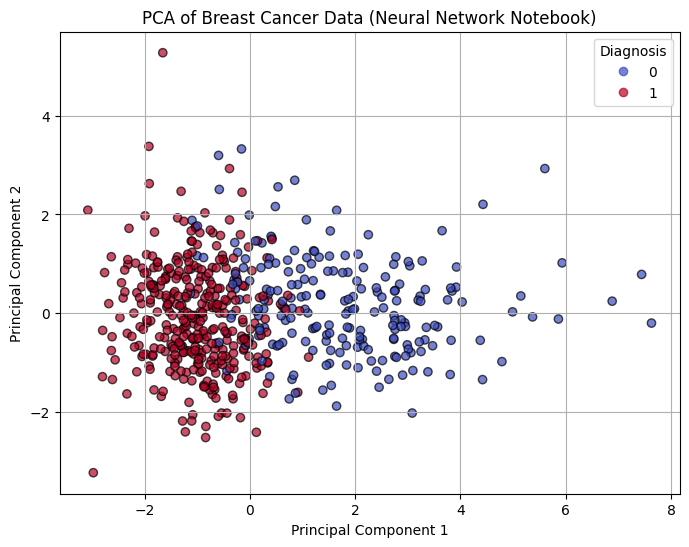

Explained variance ratio (PC1, PC2): [0.63117561 0.21585078]


In [7]:
# Principal Component Analysis (PCA)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Recreate full dataset for PCA
X_full = np.vstack((X_train, X_val, X_test))
y_full = np.hstack((y_train, y_val, y_test))

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_full)

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_full, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Breast Cancer Data (Neural Network Notebook)')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Diagnosis")
plt.show()

# Print explained variance
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)


In [8]:
def build_model(input_dim):
    model = Sequential([
        Dense(128, input_shape=(input_dim,)), BatchNormalization(), Activation('relu'), Dropout(0.4),
        Dense(64), BatchNormalization(), Activation('relu'), Dropout(0.3),
        Dense(32), Activation('relu'), Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss=focal_loss(alpha=0.3, gamma=2.0),
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model
model = build_model(X_train_up.shape[1])
model.summary()

C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,905 (46.50 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]
history = model.fit(
    X_train_up, y_train_up,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6769 - loss: 0.1081 - val_accuracy: 0.9211 - val_loss: 0.0533 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8297 - loss: 0.0412 - val_accuracy: 0.9561 - val_loss: 0.0466 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8936 - loss: 0.0270 - val_accuracy: 0.9737 - val_loss: 0.0422 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8979 - loss: 0.0307 - val_accuracy: 0.9649 - val_loss: 0.0379 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8882 - loss: 0.0328 - val_accuracy: 0.9649 - val_loss: 0.0342 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9020 - loss: 0.0233 - val_accuracy: 0.9649 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9198 - loss: 0.0229 - val_ac

X_sample.shape: (100, 5)
shap_values.shape: (100, 5, 1)


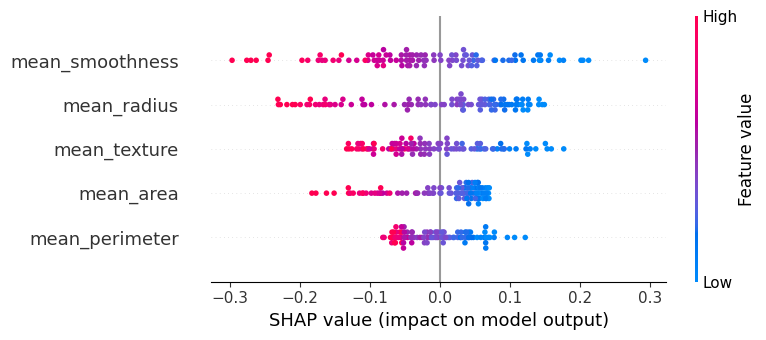

In [ ]:
# Prepare a “background” dataset for the explainer (we’ll use first 100 training examples)
background = X_train[:100]

# Create a DeepExplainer tied to your trained model
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values on a subset of your test set
# (you can bump this up/down depending on memory)
X_sample = X_test[:100]
shap_values = explainer.shap_values(X_sample)

print("X_sample.shape:", X_sample.shape)
if isinstance(shap_values, list):
    for i, sv in enumerate(shap_values):
        print(f"shap_values[{i}].shape:", np.array(sv).shape)
else:
    print("shap_values.shape:", np.array(shap_values).shape)
    
# shap_values is (100, 5, 1) → squeeze to (100, 5)
sv = shap_values.squeeze()

# Plot a summary of feature importances
# shap_values[0] corresponds to the output-class for a single-output model
shap.summary_plot(sv, X_sample, feature_names=feature_names)

SHAP plot
Each dot represents a patient.

Horizontal location = how much that feature affected the output (left = more benign, right = more malignant).

Color = feature value (red = high, blue = low).

So, for example:

High smoothness seems to push down toward benign (lots of red dots left of center).


Explaining SHAP
SHAP value: A signed number for each feature and sample showing how much that feature pushed the model’s prediction above (positive) or below (negative) the “base value” (average prediction).

Importance: The average of the absolute SHAP values across all samples, ranking features by how much they typically influence the model—regardless of direction.

Direction: A simple “up”/“down” label derived from the sign of each SHAP value, indicating whether a feature increased or decreased the prediction for that instance.


Positive SHAP value: That feature pushed the prediction toward malignant (a higher probability of cancer).

Example: A high mean_radius might strongly increase the malignancy score.

Negative SHAP value: That feature pulled the prediction toward benign (a lower probability of cancer).

Example: A smooth texture might reduce the model's confidence in a malignant diagnosis.

In [ ]:
import json

# Global feature importance as JSON ———
mean_abs_shap = np.abs(sv).mean(axis=0)
global_imp_list = [
    {"feature": feat, "importance": float(imp)}
    for feat, imp in zip(feature_names, mean_abs_shap)
]
# sort descending
global_imp_list.sort(key=lambda x: x["importance"], reverse=True)

global_importance_json = json.dumps({
    "type": "global_feature_importance",
    "values": global_imp_list
}, indent=2)

print(global_importance_json)


# Local explanation for a single sample as JSON ———
i = 0  # index of the sample you want to explain
sample_shap = sv[i].tolist()
base_value = float(explainer.expected_value[0])
model_pred = float(model.predict(X_sample[i:i+1])[0])

local_contribs = []
for feat, val in zip(feature_names, sample_shap):
    local_contribs.append({
        "feature": feat,
        "value": float(val),
        "direction": "up" if val > 0 else "down"
    })

local_explanation_json = json.dumps({
    "type":       "local_prediction_explanation",
    "sample_idx": i,
    "base_value": base_value,
    "model_output": model_pred,
    "contributions": local_contribs
}, indent=2)

print(local_explanation_json)


{
  "type": "global_feature_importance",
  "values": [
    {
      "feature": "mean_smoothness",
      "importance": 0.09477191931705597
    },
    {
      "feature": "mean_radius",
      "importance": 0.09306988537667886
    },
    {
      "feature": "mean_texture",
      "importance": 0.06649392749838155
    },
    {
      "feature": "mean_area",
      "importance": 0.05536114577432635
    },
    {
      "feature": "mean_perimeter",
      "importance": 0.04138745798084731
    }
  ]
}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
{
  "type": "local_prediction_explanation",
  "sample_idx": 0,
  "base_value": 0.561491072177887,
  "model_output": 0.06383613497018814,
  "contributions": [
    {
      "feature": "mean_radius",
      "value": -0.1868196653406313,
      "direction": "down"
    },
    {
      "feature": "mean_texture",
      "value": -0.13043347590493903,
      "direction": "down"
    },
    {
      "feature": "mean_perimeter",
      "value": -0.06909262583661437,
      "direction":

C:\Users\sebas\AppData\Local\Temp\ipykernel_20700\90093275.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model_pred = float(model.predict(X_sample[i:i+1])[0])


SHAP values tell us:
Overall: Mean Smoothness and Mean Radius have biggest influence.

Individual patient 0: 
Starting point prediction Base Value = .56 (Same for all), prediction without looking at features (avg model prediction)
Model output = .063 (for this patient) after looking at patient features, model dropped liklihood of cancer to 6% (benign)
All five features pulled the score down towards benign
Mean Radius and Mean Texture most decreased the likelihood of breast cancer for patient 0.

In [16]:
y_val_prob = model.predict(X_val).ravel()
prec, rec, thr = precision_recall_curve(y_val, y_val_prob)
idx = np.where(rec >= 1.0)[0]
best_thresh = thr[idx[-1]] if len(idx) else 0.5
print(f'Optimal Threshold: {best_thresh:.3f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Optimal Threshold: 0.316


In [17]:
y_test_prob = model.predict(X_test).ravel()
y_test_pred = (y_test_prob >= best_thresh).astype(int)
print('Recall on positive cancer test:', recall_score(y_test, y_test_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Recall on positive cancer test: 0.9722222222222222
Confusion Matrix:
 [[36  6]
 [ 2 70]]
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        42
           1       0.92      0.97      0.95        72

    accuracy                           0.93       114
   macro avg       0.93      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114



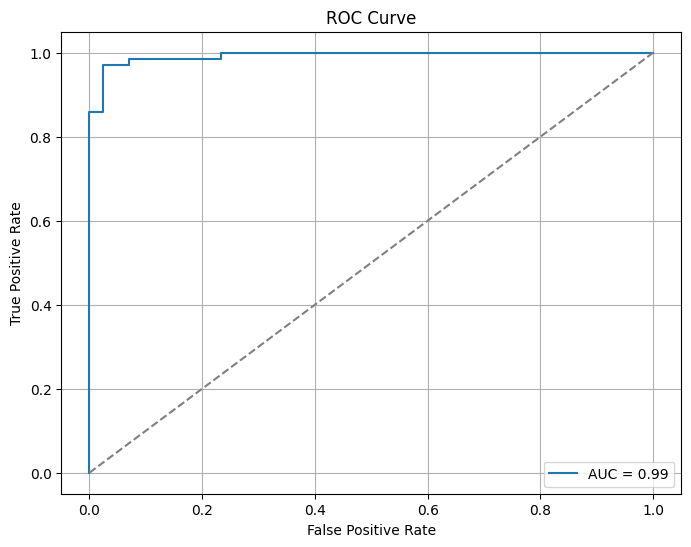

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
auc_score = roc_auc_score(y_val, y_val_prob)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
